# Introduction

Fortunately, with libraries such as Scikit-Learn, it’s now easy to build and use almost any machine learning algorithm. But it’s helpful to have an idea of how a machine learning model works under the hood. This lets us diagnose the model when it’s underperforming or explain how it makes decisions, which is crucial if we want to convince others to trust our models.
In this assignment, we’ll look at how to build and use the Decision Tree and the Random Forest in Python. We’ll start by understanding how a single decision tree makes classifications on a simple problem. Then, we’ll work our way to using a random forest on a real-world data science problem.

# Dataset

The dataset we will use in this assignment is the Sonar dataset.

This is a dataset that describes sonar chirp returns bouncing off different surfaces. The 60 predictors are the strength of the returns at different angles. It is a binary classification problem that requires a model to differentiate rocks from metal cylinders. There are 208 observations.

It is a well-understood dataset. All of the variables are continuous and generally in the range of 0 to 1. The output variable is a string “M” for mine and “R” for rock, which will need to be converted to integers 1 and 0.

By predicting the class with the most observations in the dataset (M or mines) the Zero Rule Algorithm can achieve an accuracy of 53%.

You can learn more about this dataset at the UCI Machine Learning repository.
https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)

Download the dataset for free and place it in the "data" folder in your working directory with the filename sonar.all-data.csv.

# Import section

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import tests

In [3]:
RANDOM_STATE = 2020

# Preprocess data

Read data and convert targets to integers 1 and 0.

In [4]:
PATH = 'data/'
df = pd.read_csv(PATH+'sonar-all-data.csv', header=None)
df.columns = [f'feat_{col}' if col!=60 else 'target' for col in df.columns]
df['target'] = df['target'].map({'M': 1, 'R': 0})
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0


# Split data (train and test)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df['target'], test_size=0.2, random_state=RANDOM_STATE)

# Homework part 1. Implementation of Random Forest Classifier.

## Splitting criteria

**Task 1 - 2 points.** In this section you should implement two criteria for splitting of the feature space. Any of these can be used in the model.

### Gini index

0.5 points for *gini_index* function

In [6]:
def gini_index(x):
    """ Calculate Gini Index for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Gini index
    """
    if len(x) == 0:
        return 0.0
    p = np.unique(x, return_counts=True)[1]/len(x)
    gini = 1-np.sum(p**2)
    return(gini)

In [7]:
tests.test_gini_index(gini_index)

 All good!


0.5 points for *gini_gain* function

In [8]:
def gini_gain(parent_node, splits):
    """ Calculate Gini Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Gini gain
    """
    sum_of_branches = 0
    for branch in splits:
        sum_of_branches += (gini_index(branch) * len(branch) / len(parent_node))
    gini_gain = gini_index(parent_node) - sum_of_branches
    return gini_gain

In [9]:
tests.test_gini_gain(gini_gain)

 All good!


### Entropy

0.5 points for *entropy* function. WARNING! Use only natural logarithm np.log() for calculation.

In [10]:
def entropy(x):
    """ Calculate Entropy for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Entropy
    """
    # If you use vectorized operations on a vector of frequencies p
    # where some of the relative frequencies may be 0, and you need to evaluate
    # the expression p * np.log(p), you can use the "where" argument of the np.log() function.
    # This will leave those elements of the array untouched by the function, 
    # thus evaluating x*log(x) as zero, exactly as we want it to be.
    p = np.unique(x, return_counts=True)[1]/len(x)
    entropy = np.sum(-p*np.log(p, where=True))
    return(entropy)

In [11]:
tests.test_entropy(entropy)

 All good!


0.5 points for *information_gain* function

In [12]:
def information_gain(parent_node, splits):
    """ Calculate Information Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Information Gain
    """     
    sum_of_branches = 0
    for branch in splits:
        sum_of_branches += (entropy(branch) * len(branch) / len(parent_node))
    information_gain = entropy(parent_node) - sum_of_branches
    return information_gain

In [13]:
tests.test_information_gain(information_gain)

 All good!


## Split function

**Task 2 - 1 point** Implement *split_dataset* function. <br>
The rows of the dataframe received by a tree node are split into two dataframes depending on their values in a selected column. Rows with values smaller than the chosen threshold are stored in the resulting left dataframe, and we save rows with values larger than the threshold in the right dataframe. The array with target values should be split in accordance with the feature dataframe.

In [14]:
def split(X, y, value):
    """ Split y-values in order to calculate gain later
    Args:
        X: 1-dimensional numpy-array of data predictor with shape (N,)
        y: 1-dimensional numpy-array of targets with shape (N,)
        value (float): the value by which the X should be splitted
    Returns:
        Two 1-dimensional numpy-arrays with targets related to splits
    """      
    left_mask = X < value
    right_mask = X >= value
    return y[left_mask], y[right_mask]


def split_dataset(X, y, column, value):
    """ Split dataset by a particular column and value
    Args:
        X: 2-dimensional numpy-array (N, num_feats). N-number of samples
        y: 1-dimensional numpy-array of targets with shape (N,)  
        column (int): the column by which the X should be splitted
        value (float): the value by which the column should be splitted
    Returns:
        Two 2-dimensional numpy-arrays with data and two 1-dimensional numpy-arrays with targets related to splits
        left_X, right_X, left_y, right_y
    """       
    left_mask = [raw[column] < value for raw in X]
    right_mask = [raw[column] >= value for raw in X]
    left_y, right_y = y[left_mask], y[right_mask]
    left_X, right_X = X[left_mask], X[right_mask] 
    return left_X, right_X, left_y, right_y

In [15]:
tests.test_split_dataset(split_dataset)

 All good!


## Decision tree

**Task 3 - 4.5 points** In the Tree class below you need to complete the *fit(), predict_row()* and *predict()* functions.<br>
Each tree is basically a tree node that may have a left and a right child that are also trees. If a tree doesn't have any child nodes, we call it a leaf.<br>
Since features for splitting a dataframe are chosen randomly, we need a mechanism to control this randomness to aquire reproducibility for testing purposes. In our case we use the [Random Generator](https://numpy.org/doc/stable/reference/random/generator.html)<br>
By creation of a tree only the **criterion** and the **rng** fields are not filled with Nones, so each tree knows what criterion for dataframe splitting it should use. Each fitted tree knows as well by which column and value the split should be performed. If a tree is a leaf it doesn't have information about the split, but stores the predicted value.

**_I fixed RANDOM_STATE in np.random.default_rng(RANDOM_STATE), so I have the same graphs every time I rerun my notebook_**

In [16]:
class Tree(object):
    """A decision tree classifier.

    Args:
        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
        random_gen: numpy Random Generator object, default=None
            Generator should be passed over for reproducible results. If None, 
            a new np.random.default_rng() will be created.
    """
    def __init__(self, criterion='gini', random_gen=None):
        if criterion not in ["gini", "entropy"]:
            raise ValueError(f'Unknown criteria for splits {criterion}')
        self.criterion = criterion
        self.threshold = None           # value of the next split
        self.column_index = None        # column to use for the next split
        self.outcome_probs = None       # the predicted value if the tree is a leaf
        self.left_child = None
        self.right_child = None
        self.rng = random_gen if random_gen is not None else np.random.default_rng(RANDOM_STATE)

    @property
    def is_terminal(self):
        """Define is it terminal node."""          
        return not bool(self.left_child and self.right_child)
    
    def _compute_gain(self, y, splits):
        """Compute split gain according to chosen criteria."""
        func = gini_gain if self.criterion == 'gini' else information_gain
        return func(y, splits)

    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _find_best_split(self, X, y, n_features):
        """Find best feature and value for a split. Greedy algorithm."""
        # Sample random subset of features
        subset = self.rng.choice(list(range(0, X.shape[1])), n_features, replace=False)

        max_gain, max_col, max_val = None, None, None

        for column in subset:
            split_values = self._find_splits(X[:, column])
            for value in split_values:
                splits = split(X[:, column], y, value)
                gain = self._compute_gain(y, splits)

                if (max_gain is None) or (gain > max_gain):
                    max_col, max_val, max_gain = column, value, gain
        return max_col, max_val, max_gain
    
    def _compute_outcome(self, y):
        """Save outcome probabilities for the leaf."""
        self.outcome_probs = np.around(np.sum(y) / y.shape[0])

    def fit(self, X, y, feature_frac=1.0, max_depth=None):
        """Fit model.

        Args:
            X (numpy-array):      The training input samples. 2-dimensional numpy array.
            y (numpy-array):      The target values. 1-dimensional numpy array.
            feature_frac (float): The fraction of features to use when fit is performed. Must be 
                                  between 0.0 and 1.0 (default: 1.0, i.e. all features).
            max_depth (int):      The maximum depth of the tree. If None, then nodes are expanded
                                  until all leaves are pure.
        """
        # 3 points
        
        # Make this tree a leaf and return if max_depth doesn't allow it to grow further
        if max_depth is not None and max_depth <= 0:
            return self._compute_outcome(y)
        
        if not 0.0 <= feature_frac <= 1.0:
            raise ValueError('feature_frac must lie between 0.0 and 1.0')
        # Compute the number of features to use. Should be integer number
        n_features = int(X.shape[1] * feature_frac)
        
        # Find the next split    
        column, value, gain = self._find_best_split(X, y, n_features)
        
        # Make this tree a leaf and return if the split doesn't bring any gain
        if gain is None or gain == 0:
            self._compute_outcome(y)
            return None
        
        self.threshold = value
        self.column_index = column
            
        
        # Reduce the max_depth parameter for the next tree
        if max_depth is not None:
            max_depth = max_depth - 1

        # Split dataset
        left_X, right_X, left_target, right_target = split_dataset(X, y, self.column_index, self.threshold)

        # Grow left and right child. Pass over the parent's random generator
        # for reproducible results 
        self.left_child = Tree(criterion=self.criterion, random_gen=self.rng)
        self.left_child.fit(left_X, left_target, feature_frac=feature_frac, max_depth=max_depth)

        self.right_child = Tree(criterion=self.criterion, random_gen=self.rng)
        self.right_child.fit(right_X, right_target, feature_frac=feature_frac, max_depth=max_depth)

    def predict_row(self, row):
        """Predict single row."""
        # 0.5 points
        if not self.is_terminal:
            # Use the stored information about the split to define 
            # if the right or the left child to use
            if row[self.column_index] < self.threshold:
                return self.left_child.predict_row(row)
            else:
                return self.right_child.predict_row(row)
        return self.outcome_probs

    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test input samples. 2-dimensional numpy array.
        Returns:
            1-dimensional numpy-array with predictions     
        """ 
        # 1 point
        
        # Create a numpy array of zeros of necessary length to save predictions
        result = np.zeros(len(X))
        # Go through all rows of the dataset
        for i in range(len(X)):
            # Save the prediction for the current row
            result[i] = self.predict_row(X[i])
        return result

In [17]:
tests.test_tree(Tree)

 All good!


**Task 4 - 1 point** Fit two models with "max_depth=3" and "max_depth=None" hyperparameters. **Explain** the results.

**_I decided to fit the models with different creterion_**

**_Decision tree with max_deph=3_ and criterion='gini'**

In [18]:
model = Tree(criterion='gini')
model.fit(X_train.values, y_train.values, max_depth=3)
train_score = accuracy_score(y_train, model.predict(X_train.values))
test_score = accuracy_score(y_test, model.predict(X_test.values))
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')

Train score: 0.927710843373494
Test score: 0.6666666666666666


**_Decision tree with max_deph=None and criterion='gini'_**

In [19]:
model = Tree(criterion='gini')
model.fit(X_train.values, y_train.values, max_depth=None)
train_score = accuracy_score(y_train, model.predict(X_train.values))
test_score = accuracy_score(y_test, model.predict(X_test.values))
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')

Train score: 1.0
Test score: 0.6428571428571429


**_If we compare Decision tree with max_depth=3 and criterion='gini' and decision tree with max_depth=None and creterion='gini', we can see that train score is bigger (perfect 1 score) when max_depth is None than with max_depth=3 ( 0.927710843373494). Pefrect 1 score is a sign of overfitting. These overfitted score on train witn max_depth=None can be explained by the fact that the Tree can create "infinite" amount of leafs (split, split, split, split and etc...) and so can adjust to the particular data given for the training, leading to overfitting. In this case the Tree in my humble opinion becomes more of a "if" "else" structure splitting the data in very small samples. When max_depth is 3, we put restrictions on our tree, not letting it to adjust to the training data too much. Moreover, test score is slightly smaller with max_depth=None (0.6428571428571429) than with max_depth=3 (0.6666666666666666). I explain it like this: because our model with max_depth=None gets overfitted on train, it performes worse on different data from train which is in our case - test. Likewise, because model with max_depth=3 is not overfitted like with max_depth=None, model with max_depth=3 performes a little better on test than model with max_depth=None on test._**

**_Decision tree with max_deph=3 and criterion='entropy'_**

In [20]:
model = Tree(criterion='entropy')
model.fit(X_train.values, y_train.values, max_depth=3)
train_score = accuracy_score(y_train, model.predict(X_train.values))
test_score = accuracy_score(y_test, model.predict(X_test.values))
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')

Train score: 0.8734939759036144
Test score: 0.7380952380952381


**_Decision tree with max_deph=None and criterion='entropy'_**

In [21]:
model = Tree(criterion='entropy')
model.fit(X_train.values, y_train.values, max_depth=None)
train_score = accuracy_score(y_train, model.predict(X_train.values))
test_score = accuracy_score(y_test, model.predict(X_test.values))
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')

Train score: 1.0
Test score: 0.7142857142857143


**_If we compare decision tree with max_depth=3 and criterion='entropy' and decision tree with max_depth=None and creterion='entropy', there is the same pattern. Decision tree with max_depth=None and creterion='entropy' is overfitted (1 score) because it can split as much as it wants and adjusts to much to the training data. Decision tree with max_depth=3 and criterion'entropy' has a score 0.8734939759036144. Moreover, similarly test score with max_depth=None (0.7142857142857143) is slightly smaller than with max_depth=3 (0.7380952380952381) I think because the model with max_depth=None adjusts to training to much and performs worse on test._**

**_To underline, if we compare criterion='gini' and criterion='entropy', with max_depth=3 train is better with gini compared to entropy while test is better with entropy compared to gini. With max_depth=None, train is the same overfitted while test is better with entropy (0.7142857142857143) compared to gini (0.6428571428571429). Overall, test is better with entropy but I think it is just explained by the particular dataset because I researched and the difference that most people underline between using entropy and gini is that it takes more time to compute entropy (it uses logarithm) and there is nothing about the fact that one is better than another for the accuracy. It all depends on the dataset. To conclude, in the task we are only asked to compare the difference between max_depth, and my speculations about 'entropy' and 'gini' are just my additional thoughts._**

In [22]:
import tqdm.notebook as tqdm

In [23]:
def plot_metrics_on_depths(criterion='gini'):
    max_depths, train_scores, test_scores = [], [], []
    for max_depth in tqdm.tqdm(range(0, 8)):
        max_depths.append(max_depth)
        model = Tree(criterion=criterion)
        model.fit(X_train.values, y_train.values, max_depth=max_depth)
        train_scores.append(accuracy_score(y_train, model.predict(X_train.values)))
        y_pred = model.predict(X_test.values)
        test_scores.append(accuracy_score(y_test, y_pred))
    res_metrics = pd.DataFrame(data={'train': train_scores, 'test': test_scores}, index=max_depths)
    sns.set(rc={'figure.figsize':(16, 6)})
    plt.plot(res_metrics['train'], label='train score')
    plt.plot(res_metrics['test'], label='test score')
    plt.title("Accuracy as a function of max_depth")
    plt.xlabel('max_depth')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show();

  0%|          | 0/8 [00:00<?, ?it/s]

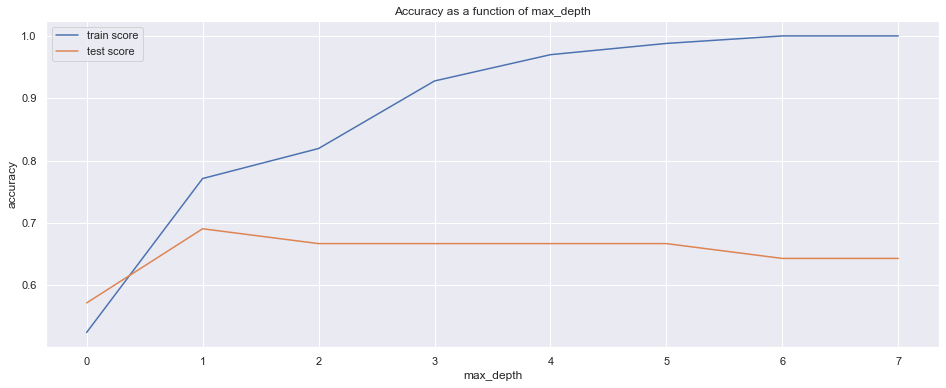

In [24]:
plot_metrics_on_depths('gini')

**_Moreover, I will add some thoughts about the graphs. For 'gini' with the increase of max_depth we see a stable increase in accuracy on train. As I said before, it has to do with overfitting. The tree splits so much that with max_depth=6 it achieves perfect fit. However, with test happens another thing. After max_depth=1, accuracy on test starts slightly decreasing. I think it is because the tree fits too much the train, it becomes worse on test._**

  0%|          | 0/8 [00:00<?, ?it/s]

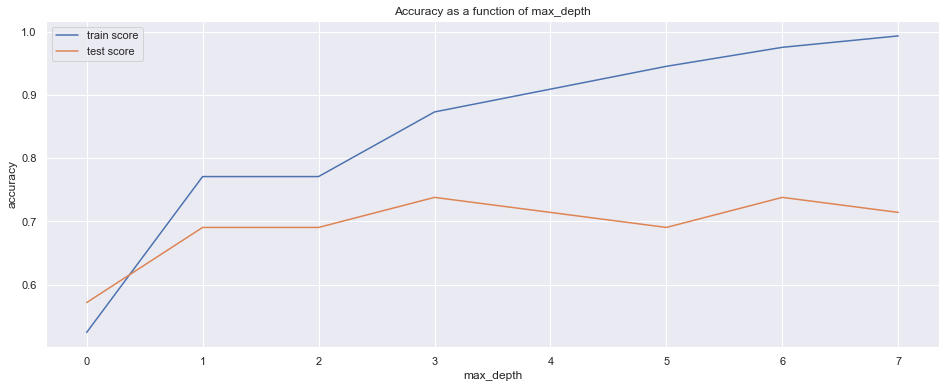

In [25]:
plot_metrics_on_depths('entropy')

**_Finally, I will add some thoughts about the graph for 'entropy'. With the increase of max_depth, the train accuracy increases. However, there is a spot when the increase of max_depth from 1 to 2 doesn't change accuracy. May be it happens just because of the particular dataset (our split doesn't give us any increase in accuracy). Moreover, after max_depth=3 accuracy on test decreases and then increases and then again decreases. I think it is again because of the dataset (just some splits make accuracy worse, some return it back). Overall, test score doesn't grow higher than at point with max_depth=3, so I think it is again because the tree adjusts too much to train._**

## Random forest

**Task 5 - 1.5 Points** In the RandomForestClassifier class below you need to complete the *fit* and *predict()* functions

In [26]:
class RandomForestClassifier(object):
    """
    A random forest classifier.
    A random forest is a meta estimator that fits a number of decision tree
    classifiers on various sub-samples of the dataset and uses averaging to
    improve the predictive accuracy and control overfitting.
    
    Args:
        n_estimators : int, default=10
            The number of trees in the forest.

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        feature_frac : float, default=None
            The fraction of features to use when looking for the best split. Must be 
            between 0.0 and 1.0. If None, then `feature_frac = 1 / sqrt(n_features)`.

        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
            
        random_gen: numpy Random Generator object, default=None
            Generator should be passed over for reproducible results. If None, 
            a new np.random.default_rng() will be created.
    """

    def __init__(self, n_estimators=10, max_depth=None, feature_frac=None, 
                 criterion="entropy", bootstrap=True, random_gen=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.bootstrap = bootstrap
        self.feature_frac = feature_frac
        
        if criterion not in ["gini", "entropy"]:
            raise ValueError(f'Unknown criteria for splits {criterion}')
        self.criterion = criterion
        
        self.rng = random_gen if random_gen is not None else np.random.default_rng(RANDOM_STATE)
        self.trees = [Tree(criterion=self.criterion, random_gen=self.rng) 
                            for _ in range(n_estimators)]
        
    def _init_data(self, X, y):
        """Ensure data are in the expected format.
        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. 
        Parameters
        Args:
            X : array-like
                Feature dataset.
            y : array-like, default=None
                Target values. By default is required, but if y_required = false
                then may be omitted.
        """
        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        return self.rng.integers(size, size=size)
    
    def fit(self, X, y):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
        """
        # 0.5 points
        
        if self.feature_frac is None:
            self.feature_frac = 1 / np.sqrt(X.shape[1])
        elif not 0.0 <= self.feature_frac <= 1.0:
            raise ValueError('feature_frac must lie between 0.0 and 1.0')
            
        self._init_data(X, y)
        
        # Iterate over all trees in the forest
        for tree in self.trees:
            if self.bootstrap:
                idxs = self.bootstrap_data(self.size)
                X = self.X[idxs]
                y = self.y[idxs]
            else:
                X = self.X
                y = self.y
                
            # Fit the tree    
            tree.fit(X, y, feature_frac=self.feature_frac, max_depth=self.max_depth)
            
    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test data input samples. 2-dimensional numpy array.
        """
        # 1 point
        
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            # Create a numpy array of zeros of necessary length
            predictions = np.zeros(len(X))
            # Go through all rows of the dataset
            for i in range(len(X)):
                # Initialize a counter for voting
                row_pred = []
                # Sum up predictions from all the voters
                for tree in self.trees:
                    row_prediction = tree.predict_row(X[i])
                    row_pred.append(row_prediction)
                # Compute the mean of the votes    
                row_pred = np.mean(row_pred)
                # Save the rounded value as the prediction for the current row
                predictions[i] = round(row_pred)
            return predictions  
        else:
            raise ValueError("You should fit a model before `predict`")

In [27]:
tests.test_random_forest(RandomForestClassifier)

 All good!


**Task 6 - 1 Point** Fit two models with "n_estimators=10" and "n_estimators=100" hyperparameters. **Explain** the results.

**_Random Forest with n_estimators=10 and criterion='gini'_**

In [28]:
model = RandomForestClassifier(n_estimators=10, max_depth=4, feature_frac=None, criterion="gini")
model.fit(X_train, y_train)
train_score = accuracy_score(y_train, model.predict(X_train.values))
test_score = accuracy_score(y_test, model.predict(X_test.values))
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')

Train score: 0.9337349397590361
Test score: 0.7380952380952381


**_Random Forest with n_estimators=100 and criterion='gini'_**

In [29]:
model = RandomForestClassifier(n_estimators=100, max_depth=4, feature_frac=None, criterion="gini")
model.fit(X_train, y_train)
train_score = accuracy_score(y_train, model.predict(X_train.values))
test_score = accuracy_score(y_test, model.predict(X_test.values))
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')

Train score: 1.0
Test score: 0.8571428571428571


**_Explanation of the results above: as we can see with criterion='gini', train score with n_estimators=10 is very good (0.9337349397590361) and with n_estimators=100 is perfect (1.0) which in the case of RandomForest with this particular dataset I wouldn't call an overfitting. Let me explain. N_estimators is the number of trees in the forest from which opinion we take the maximum voting or averages of predictions. The more n_estimators, the more amoung of trees "opinions" we take into account and the more accurate our model becomes. It is the advantage of a RandomForest. However, we don't put too much of n_estimators, so our computer can handle the calculations. Consequently, I don't believe that this is an overfitting. Also, the accuracy on test for n_estimators=10 is 0.7380952380952381 and n_estimatoes=100 is 0.8571428571428571 (to underline, the accuracy on test with n_estimators=100 is better than with n_estimators=10) which I think indicates that we don't have overfitting with n_estimators=100 because if our model would too much adjust to train (be overfitted), it would perform worse on test with n_estimators=100 than n_estimators=10. In our case, it is the opposite._**

Let's test the same thing with entropy.

**_Random Forest with n_estimators=10 and criterion='entropy'_**

In [30]:
model = RandomForestClassifier(n_estimators=10, max_depth=4, feature_frac=None, criterion="entropy")
model.fit(X_train, y_train)
train_score = accuracy_score(y_train, model.predict(X_train.values))
test_score = accuracy_score(y_test, model.predict(X_test.values))
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')

Train score: 0.9397590361445783
Test score: 0.8571428571428571


**_Random Forest with n_estimators=100 and criterion='entropy'_**

In [31]:
model = RandomForestClassifier(n_estimators=100, max_depth=4, feature_frac=None, criterion="entropy")
model.fit(X_train, y_train)
train_score = accuracy_score(y_train, model.predict(X_train.values))
test_score = accuracy_score(y_test, model.predict(X_test.values))
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')

Train score: 0.9939759036144579
Test score: 0.7857142857142857


**_With entropy, we get pretty high result on train with n_estimators=10 (0.9397590361445783) and almost perfect score with n_estimatoes=100 (0.9939759036144579). Again, I wouldn't call it an onverfitting because of the same reasons as with 'gini'. However, the score on test with n_estimators=10 is 0.8571428571428571 and n_estimators=100 is 0.7857142857142857 which is smaller, so let's examine it deeper._**

**_Let's change the max_depth to 10 and see how accuracy changes with entropy and different n_estimators._**

**_Random Forest with n_estimators=10 and criterion='entropy' and max_depth = 10_**

In [32]:
model = RandomForestClassifier(n_estimators=10, max_depth=10, feature_frac=None, criterion="entropy")
model.fit(X_train, y_train)
train_score = accuracy_score(y_train, model.predict(X_train.values))
test_score = accuracy_score(y_test, model.predict(X_test.values))
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')

Train score: 0.9879518072289156
Test score: 0.7619047619047619


**_Random Forest with n_estimators=100 and criterion='entropy' and max_depth = 10_**

In [33]:
model = RandomForestClassifier(n_estimators=100, max_depth=10, feature_frac=None, criterion="entropy")
model.fit(X_train, y_train)
train_score = accuracy_score(y_train, model.predict(X_train.values))
test_score = accuracy_score(y_test, model.predict(X_test.values))
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')

Train score: 1.0
Test score: 0.8809523809523809


**_As we can see when we changed max_depth=10, our score on test with n_estimators=10 (0.7619047619047619) is lower than with n_estimators=100 (0.8809523809523809). So I tend to think that our initial high score on train is not the case of overfitting because of the increase in n_estimators. Moreover, to underline max_depth influences the model very much (even leads to overfitting with some values), so the model is influenced by the combination of max_depth and n_estimators._**

**_Now let's go deeper into 'gini' because with n_estimators=100 and 'gini' we get a perfect score on train. I think the perfect score is influenced by the max_depth. Let's change max_depth with 'gini' and see how the results change._**

**_Random Forest with n_estimators=10 and criterion='gini' and max_depth=1_**

In [34]:
model = RandomForestClassifier(n_estimators=10, max_depth=1, feature_frac=None, criterion="gini")
model.fit(X_train, y_train)
train_score = accuracy_score(y_train, model.predict(X_train.values))
test_score = accuracy_score(y_test, model.predict(X_test.values))
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')

Train score: 0.7530120481927711
Test score: 0.5952380952380952


**_Random Forest with n_estimators=100 and criterion='gini' and max_depth=1_**

In [35]:
model = RandomForestClassifier(n_estimators=100, max_depth=1, feature_frac=None, criterion="gini")
model.fit(X_train, y_train)
train_score = accuracy_score(y_train, model.predict(X_train.values))
test_score = accuracy_score(y_test, model.predict(X_test.values))
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')

Train score: 0.8192771084337349
Test score: 0.7619047619047619


**_With max_depth=1 and 'gini', both train and test scores increase with n_estimators=100. However, the scores are not perfect. It indicates 2 things: 1) increasing the amount of estimators can increase the score 2) Max_depth influences the model very much and the combination of max_depth and n_estimators can give us a perfect score (which can be a sign of overfitting in some cases but NOT in all)._**

**_Moreover, I want to underline that the model accuracy is slightly different when we use 'gini' and when we use 'entropy' and I think it all depends on the dataset._**

Now it's your turn to explore the various parameters of RandomForestClassifier and their influence on model quality.

# Homework part 2. Random Forest in action

_Note_: Consider **accuracy** as main metric of model performance on this dataset.

_Note_: For tasks 1 to 5 please use your custom RandomForestClassifier if it is completed.

**Task 1 (0.5 points)** Split the dataset into train, test and validation parts (0.6 / 0.2 / 0.2). First two will be used for model hyperparameter tuning whereas the best model quality should be evaluated on validation part.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df['target'], test_size=0.2, random_state=RANDOM_STATE)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)

In [37]:
df.shape

(208, 61)

In [38]:
X_train.shape

(124, 60)

In [39]:
X_test.shape

(42, 60)

In [40]:
X_val.shape

(42, 60)

__*As we can see by the lengths above, the split is correct*__

### Grid Search and Random Search

If you have enough computational power for model training in a reasonable amount of time more sophisticated approach of hyperparameter tuning would be either Grid Search or Random Search.<br>

In a nutshell Grid Search allows you to pass through all different combinations of given model parameters and their values and choose the best combination. Whereas Random Search would randomly choose values for given model parameters and evaluate them on test data untill it reaches the specified number of iterations.<br>

More information here [Gentle introduction to Grid and Random search](https://medium.com/@senapati.dipak97/grid-search-vs-random-search-d34c92946318) and here [Detailed Explanation with code examples](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/).

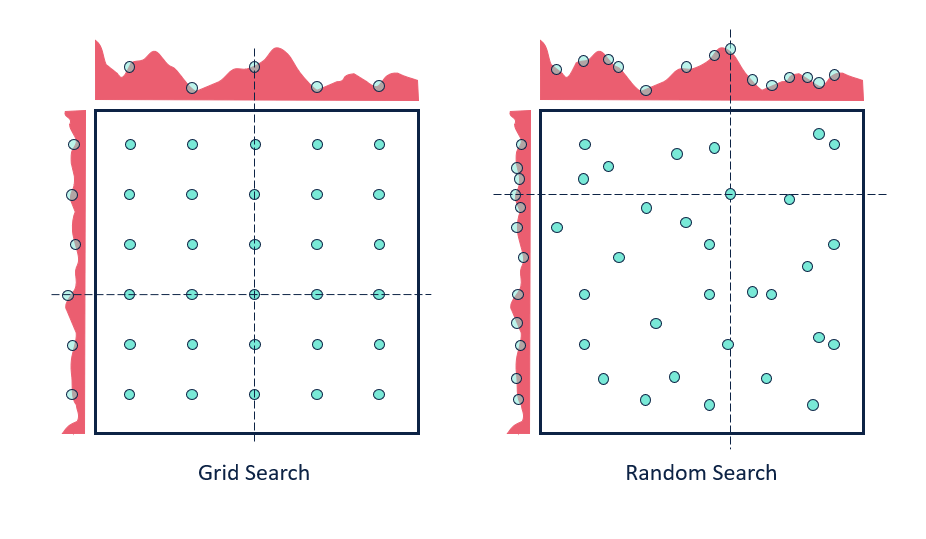

**Task 3 (1 point)**. Compare your previous results with [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) hyperparameter tuning. You may tune best hyperparameters for forest with several trees and then increase it while measure the quality on validation dataset.

**_Before implementing anything, I will underline that we do not need to split our data in 3 parts (train, test and val)for GridSearchCV or RansomizedSEarchCV because they train on train data and use cross-validation (splitting test data that we give her using "cv" parameters) and then use validation dataset to test itself, so I will split the dataset again but only in train 80% of the data and val 20% of the data. After that with GridSearchCV and RandomizedSearchCV I will use a parameter cv=4, so 60% of train data will be used for training and 20% of training data will be used for testing in cross-validation. By doing like this I will achieve the same split into train, test, and val but without declaring below the test dataset._**

In [41]:
X_train, X_val, y_train, y_val = train_test_split(df.drop(columns='target'), df['target'], test_size=0.2, random_state=RANDOM_STATE)

In [52]:
len(X_train)

166

In [51]:
len(X_train)/len(df)

0.7980769230769231

**_As we can see above train's length is 166 which is 80% of df. (Later train will be split by a cross-validation in SearchCV into train and test)_**

In [53]:
len(X_val)

42

In [50]:
len(X_val)/len(df)

0.20192307692307693

**_As we can see above validation's length is 20% of df_**

**_As I understood the task we need to use hyperparameters tuning on the forest with several trees and more than several trees. That's why I made 2 GridSearchCV (and 2 RandomizedSeachCV in task 4), so I have GridSearchCv with n_estimators=10 and GridCv with n_estimators=100_**

**_Tune best hyperparameters for forest with several trees (let's take 10 trees)_**

In [44]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [int(x) for x in np.linspace(3, 20, num = 10)],
    'max_features': [2, 4, 'sqrt'],
    'min_samples_leaf': [int(x) for x in np.linspace(2, 8, num=6)],
    'min_samples_split': [int(x) for x in np.linspace(2, 8, num=6)],
    'n_estimators': [10],
    'criterion': ['entropy', 'gini']
}

rf = RandomForestClassifier(random_state=RANDOM_STATE)

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 4, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
print(f'Best parameters: {grid_search.best_params_}')
best_grid = grid_search.best_estimator_
train_score = accuracy_score(y_train, best_grid.predict(X_train))
test_score = accuracy_score(y_val, best_grid.predict(X_val))
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')

Fitting 4 folds for each of 4320 candidates, totalling 17280 fits
Best parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 6, 'max_features': 4, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 10}
Train score: 1.0
Test score: 0.8333333333333334
Wall time: 1min 17s


**_Tune best hyperparameters for forest with many trees (let's take 100 trees)_**

In [45]:
%%time
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [int(x) for x in np.linspace(3, 20, num = 10)],
    'max_features': [2, 4, 'sqrt'],
    'min_samples_leaf': [int(x) for x in np.linspace(2, 8, num=6)],
    'min_samples_split': [int(x) for x in np.linspace(2, 8, num=6)],
    'n_estimators': [100],
    'criterion': ['entropy', 'gini']
}

rf = RandomForestClassifier(random_state=RANDOM_STATE)

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 4, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
print(f'Best parameters: {grid_search.best_params_}')
best_grid = grid_search.best_estimator_
train_score = accuracy_score(y_train, best_grid.predict(X_train))
test_score = accuracy_score(y_val, best_grid.predict(X_val))
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')

Fitting 4 folds for each of 4320 candidates, totalling 17280 fits
Best parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Train score: 1.0
Test score: 0.8333333333333334
Wall time: 12min 25s


**_Comparison between previous results and with GridSearchCV_**

**_As "previous results" in context of this task I understood 2 things:_**
1. **_the results of a RandomForest from task #6 from the first half of a task (to underline, there we use a custom random forest built from scratch, so their comparison cannot be fair). Anyway, if we analyze we will see that the custom Random Forest had better results on test with n_estimators=100 and criterion='entropy' and max_depth = 10 (0.8809523809523809) than RandomForest from library after GridSearchCV n_estimators=10 (0.8333333333333334) and n_estimators=100 (0.8333333333333334). However, those RandomForests as I said are different (one from library, another one custom) and Test and Train datasets are different (for example, for this task I splited the dataset to Test and Train again with Test being 40% of data and not 20% as for the custom RandomForest), so their comparison is not logical. Moreover, RandomForests with hyperparameter tuning achieves 1.0 perfect score on train with n_estimators=10 and n_estimators=100 while custom RandomForest in task #6 (first half of the homework), only with certain max_depth.
It is undestandable because hyperparameter tuning adjusts parameters to achieve the best results on train._**
2. **_Anyway, it is not fare to compare here Custom and library RandomForests, so let's run a RandomForest from scikit learn with default parameters and compare GridSearchCV with it._**

**_RandomForest without hyperparameters tuning and n_estimators=10_**

In [46]:
model = RandomForestClassifier(n_estimators=10, random_state=RANDOM_STATE)
model.fit(X_train, y_train)
train_score = accuracy_score(y_train, model.predict(X_train))
test_score = accuracy_score(y_val, model.predict(X_val))
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')

Train score: 1.0
Test score: 0.6666666666666666


**_RandomForest without hyperparameters tuning and n_estimators=100_**

In [47]:
model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
model.fit(X_train, y_train)
train_score = accuracy_score(y_train, model.predict(X_train))
test_score = accuracy_score(y_val, model.predict(X_val))
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')

Train score: 1.0
Test score: 0.8809523809523809


**_As we can see all RandomForests from library (with and without hyperparameter tuning) achieved perfect 1.0 score on train. However, on tests RandomForests with hyperparameter tuning achieved better results with n_estimators=10 (0.8333333333333334) compared to (0.6666666666666666) without the tuning, and worse results with n_estimators=100 (0.8333333333333334) compared to (0.8809523809523809) without the tuning. To conclude, GridSearchCV helped us and increased the accuracy with n_estimators=10 but not with n_estimators=100 (but I believe that it is not a rule and if we tried other big numbers of n_estimators results with tuning could be better)_**

**_Comparison between GridSearchCV with n_estimators=10 (several trees) and GridSearchCV with n_estimators=100 (many trees)_**

**_GridSearchCV with n_estimators=10 performed the same on train and test (Train score: 1.0, Test score: 0.8333333333333334) as GridSearchCV with n_estimators=100 (Train score: 1.0, Test score: 0.8333333333333334). However, GridSearchCV with n_estimators=10 was calculating on my computer for around 1 minute while GridSearchCv with n_estimators=100 was calculating during more than 6 minutes_**

**Task 4 (1 point)**. And finally tune forest hyperparameters with [RandomSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Compare results to previous attempts.

In [48]:
%%time
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [int(x) for x in np.linspace(3, 30, num = 10)],
    'max_features': [2, 4, 'sqrt'],
    'min_samples_leaf': [int(x) for x in np.linspace(2, 8, num=6)],
    'min_samples_split': [int(x) for x in np.linspace(2, 8, num=6)],
    'n_estimators': [10],
    'criterion': ['entropy', 'gini']
}

rf = RandomForestClassifier(random_state=RANDOM_STATE)
random_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 10, cv = 4, random_state=RANDOM_STATE, n_jobs = -1)
random_search.fit(X_train, y_train)
print(f'Best parameters: {random_search.best_params_}')
best_random = random_search.best_estimator_
train_score = accuracy_score(y_train, best_random.predict(X_train))
test_score = accuracy_score(y_val, best_random.predict(X_val))
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')

Best parameters: {'n_estimators': 10, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 4, 'max_depth': 30, 'criterion': 'gini', 'bootstrap': False}
Train score: 1.0
Test score: 0.7857142857142857
Wall time: 341 ms


In [49]:
%%time
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [int(x) for x in np.linspace(3, 30, num = 10)],
    'max_features': [2, 4, 'sqrt'],
    'min_samples_leaf': [int(x) for x in np.linspace(2, 8, num=6)],
    'min_samples_split': [int(x) for x in np.linspace(2, 8, num=6)],
    'n_estimators': [100],
    'criterion': ['entropy', 'gini']
}

rf = RandomForestClassifier(random_state=RANDOM_STATE)
random_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 10, cv = 4, random_state=RANDOM_STATE, n_jobs = -1)
random_search.fit(X_train, y_train)
print(f'Best parameters: {random_search.best_params_}')
best_random = random_search.best_estimator_
train_score = accuracy_score(y_train, best_random.predict(X_train))
test_score = accuracy_score(y_val, best_random.predict(X_val))
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')

Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 2, 'max_depth': 27, 'criterion': 'entropy', 'bootstrap': True}
Train score: 1.0
Test score: 0.8809523809523809
Wall time: 1.93 s


**_Comparison between previous results and with RandomizedSearchCV_**

1. RandomizedSeachCV vs Custom RandomForest without hyperparameters tuning

2. RandomizedSeachCV vs RandomForest from a library without hyperparameters tuning

3. RandomizedSeachCV vs GridSearchCV

**_Comparison between RandomizedSearchCV with n_estimators=10 and RandomizedSearchCV with n_estimators=100_**

**Task 5 (0.5 points)**. Tell us about your experience in hyperparameter tuning with the approaches above. What do you think would be the best option for this task and why?

GridCV - 

RandomizedSeachCV - 

The main difference I found between GridCV and RandomizedSearchCV:
1. Time.
2. Accuracy with the same n_estimators.

### Desicion tree explained

Remember the [Titanic](https://www.kaggle.com/c/titanic) competition from last week? Wouldn't be a good idea to visualize one of possible desicion-making processes of _survived_ / _dead_ labeling?

**Task 6 (1 point)**. Load titanic dataset, split it into train/test parts, apply simple hyperparameter tuning of [DesicionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) (use one of the approaches above) in order to have **test accuracy more than 0.65**. <br>

Draw the best tree decision making process. You may use [sklearn.tree.prot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html).<br>

**_Load titanic dataset_**

In [142]:
import os
PATH = "./data/"
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [143]:
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C
99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S
99997,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S


**_Simple feature engineering and filling NaNs_**

In [144]:
data.drop(columns='Name', inplace=True)
data.drop(columns='Cabin', inplace=True)
data.drop(columns='Ticket', inplace=True)

data['Sex'] = data['Sex'].map({'male': 1,'female': 0})

data['Embarked'] = data['Embarked'].map({'S': 1,'Q': 0, 'C': 2})
data = data.fillna('0')

In [145]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Survived  100000 non-null  int64 
 1   Pclass    100000 non-null  int64 
 2   Sex       100000 non-null  int64 
 3   Age       100000 non-null  object
 4   SibSp     100000 non-null  int64 
 5   Parch     100000 non-null  int64 
 6   Fare      100000 non-null  object
 7   Embarked  100000 non-null  object
dtypes: int64(5), object(3)
memory usage: 6.9+ MB


**_Split it into train and test parts_**

In [147]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='Survived'), data['Survived'], test_size=0.2, random_state=RANDOM_STATE)

In [148]:
len(X_train), len(X_test), len(y_train), len(y_test)

(80000, 20000, 80000, 20000)

**_Apply simple hyperparameters tuning of DecisionTreeClassifier_**

In [153]:
%%time
from sklearn.tree import DecisionTreeClassifier
param_grid = {
    'splitter': ['best', 'random'],
    'max_depth': [3],
    'max_features': ['log2', 'sqrt'],
    'min_samples_leaf': [int(x) for x in np.linspace(2, 8, num=6)],
    'min_samples_split': [int(x) for x in np.linspace(2, 8, num=6)],
    'criterion': ['entropy', 'gini']
}

tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
random_search = RandomizedSearchCV(estimator = tree, param_distributions = param_grid, n_iter = 10, cv = 4, random_state=RANDOM_STATE, n_jobs = -1)
random_search.fit(X_train, y_train)
print(f'Best parameters: {random_search.best_params_}')
best_random = DecisionTreeClassifier(**random_search.best_params_, random_state=RANDOM_STATE)
best_random.fit(X_train, y_train)
train_score = accuracy_score(y_train, best_random.predict(X_train))
test_score = accuracy_score(y_test, best_random.predict(X_test))
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')

Best parameters: {'splitter': 'best', 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'entropy'}
Train score: 0.758
Test score: 0.76145
Wall time: 1.97 s


**_As you can see test score on DecisionTreeClassifier is 0.76 which is bigger than 0.65 required in the task_**

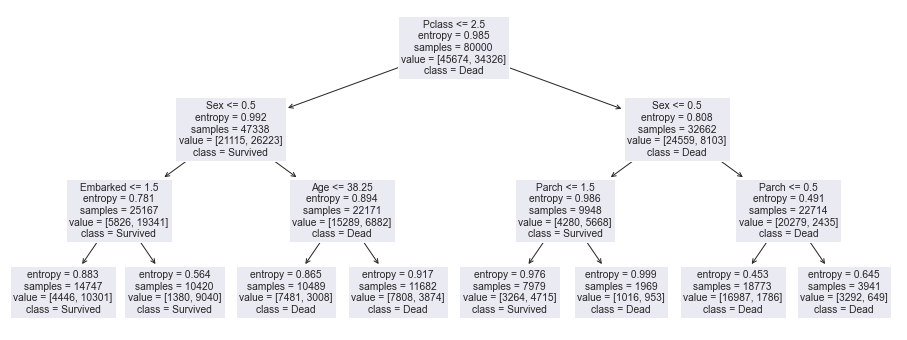

In [159]:
from sklearn import tree
tree.plot_tree(decision_tree=best_random, feature_names=data.drop(columns='Survived').columns, class_names=['Dead', 'Survived'])
plt.show()

Is it easy to interpret its results? Are you able to explain to a random person why would they survive / die on the titanic?

**_It is relatively easy to interpret results in my opinion. To undeline, we need to remember that I changed in Sex column 'male' to 1 and'female' to 0, in Embarked column 'S' to 1,'Q' to 0, 'C' to 2. Also, we need to know that left branch means True and right branch means False. Moreover, we need to know that samples is the amount of passengers who ended up in this branch, and in values values[0] means the amount of Passengers who died and values[1] is the amount of passengers who survived._**

**_I think I will be able to explain a random person why whould they survive/die on the titanic. To examplify, let's take a random row (a random person from the dataset)._**

In [162]:
data.iloc[5677]

Survived        1
Pclass          1
Sex             0
Age          54.0
SibSp           0
Parch           0
Fare        85.55
Embarked      2.0
Name: 5677, dtype: object

**_To predict whether a person will survive or not we will use a plotted decision tree above.The person above has a Pclass=1 which is smaller than 2.5 in our condition at the node, so he goes into a left (True) branch. Then, I would say that his Sex=0 which is smaller than 0.5 in the condition in the node that's why he goes into a left (True) branch again. Finally, I would say that the persons Embarked=2.0 which is bigger than 1.5 at our condition at the node, so he goes into a right (False) branch and ends up classified as 'Survived'. In other words, based on his Pclass, Sex and Embarked he would survive._**